In [53]:
import gc, math, pickle, datetime, os, random
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [54]:
def reduce_mem_usage(df, verbose=True):
    """
    :param df: Dataframe with columns unprocessed so they use more memory than needed
    
    :returns:
        df -> Dataframe with lower memory use
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df



In [95]:
def clean_timestamps(df):
    """
    :param df: Dataframe containing a "timestamp" field which will be broken down in hour, year, day,...
    """
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df["year"] = df["timestamp"].dt.year.astype(np.uint16)
    df["month"] = df["timestamp"].dt.month.astype(np.uint8)
    df["day"] = df["timestamp"].dt.day.astype(np.uint8)
    df["hour"] = df["timestamp"].dt.hour.astype(np.uint8)
    df["weekend"] = df["timestamp"].dt.weekday.astype(np.uint8)
    
def drop_cols(df):
    """
    :param df: Dataframe with unnecessary cols
    
    :returns:
            df -> dataframe containing only the desired columns
    """
    #drop_cols = ['timestamp','primary_use', 'site_id', 'floor_count',"precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed", "building_id"]
    drop_cols = ['timestamp']
    df = df.drop(drop_cols, axis = 1)
    return df

# Predictions lower than zero are turned zero
def fix_predictions(y):
    """
    :param y: Column with predictions
    """
    y[y < 0] = 0

# Fill given categories with their average values
def fill_averages(df):
    """
    :param df: Dataframe containing normal and nan values
    """
    data_ratios = df.count()/len(df)
    cols = data_ratios[data_ratios < 1.0].index
    for col in cols:
        df[col] = df[col].fillna(-1)
        df[col] = df[col].astype(np.int8)
        more_zero = df[col] >= 0
        less_zero = df[col] < 0
        mean = df[more_zero][col].mean()
        df.loc[less_zero, col] = mean

## Download  data

In [104]:
train = pd.read_csv('ashrae-energy-prediction/train.csv')
test = pd.read_csv('ashrae-energy-prediction/test.csv')
weather_train= pd.read_csv('ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('ashrae-energy-prediction/weather_test.csv')
meta = pd.read_csv('ashrae-energy-prediction/building_metadata.csv')

In [105]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)
meta= reduce_mem_usage(meta)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [106]:
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

In [107]:
#description(train)

In [108]:
#description(weather_train)

In [109]:
# description(meta)

In [110]:
train = train.merge(meta, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test =test.merge(meta, on='building_id', how='left')
test =test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [ ]:
del weather_test
del weather_train
del meta
gc.collect()

In [58]:
# test = reduce_mem_usage(pd.read_csv('ashrae-energy-prediction/test.csv'))

Mem. usage decreased to 596.49 Mb (53.1% reduction)


In [111]:
print(train.shape)
print(test.shape)

(20216100, 16)
(41697600, 16)


## Preprocessing

In [112]:
clean_timestamps(train)

In [113]:
train = drop_cols(train)

train_y = np.log1p(train['meter_reading'])

train_x = train.drop('meter_reading', axis=1)
train_x['primary_use'] = LabelEncoder().fit_transform(train_x['primary_use'])

train_x.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,weekend
0,0,0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,2016,1,1,0,4
1,1,0,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,2016,1,1,0,4
2,2,0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,2016,1,1,0,4
3,3,0,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,2016,1,1,0,4
4,4,0,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,2016,1,1,0,4


In [ ]:
del train
gc.collect()

##  LGBM 

In [69]:
# Train and Validation splits
test_size = 0.20
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=test_size, random_state=SEED)

In [70]:
  lgb_params = {
                    'objective':'regression',
                    'boosting_type':'gbdt',
                    'metric':'rmse',
                    'n_jobs':-1,
                    'learning_rate':0.07,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.5,
                    'n_estimators':8500,
                    'max_bin':255,
                    'verbose':1,
                    'seed': SEED,
                    'early_stopping_rounds':3500, 
                } 

In [71]:
del train_x
del train_y

gc.collect()

66

In [72]:
# load model once already trained
#print('Loading model')
#gbm = lgb.Booster(model_file= PATH + 'lgb_classifier_24-10-2019.txt')

In [73]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val)
gbm = lgb.train(lgb_params,
            lgb_train,
            num_boost_round=5000,
            valid_sets=(lgb_train, lgb_eval),
            verbose_eval = 50
           )

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.382491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 16100484, number of used features: 19
[LightGBM] [Info] Start training from score 4.144695
Training until validation scores don't improve for 3500 rounds
[50]	training's rmse: 1.11865	valid_1's rmse: 1.11757
[100]	training's rmse: 0.949788	valid_1's rmse: 0.948884
[150]	training's rmse: 0.880915	valid_1's rmse: 0.880579
[200]	training's rmse: 0.839004	valid_1's rmse: 0.839112
[250]	training's rmse: 0.805925	valid_1's rmse: 0.80639
[300]	training's rmse: 0.78316	valid_1's rmse: 0.784037
[350]	training's rmse: 0.765444	valid_1's rmse: 0.766826
[400]	training's rmse: 0.750916	valid_1's rmse: 0.752742
[450]	training's rmse: 0.734874	valid_1's rmse: 0.737289
[500]	training's rmse: 0.721438	valid_1's rmse: 0.724419
[550]	training's rmse: 0

# Predicting validation data

In [74]:
y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)

## Postprocessing

In [75]:
fix_predictions(y_pred)

## RMSLE 

In [76]:
rmsle = np.sqrt(mean_squared_log_error(y_pred, (y_val)))
print('RMSLE: ', rmsle)

RMSLE:  0.1899043728451411


## Saving the model

In [77]:
gbm.save_model('lgb_classifier_{}_{}.txt'.format(datetime.datetime.now().strftime("%d-%m-%Y"), rmsle), num_iteration=gbm.best_iteration)

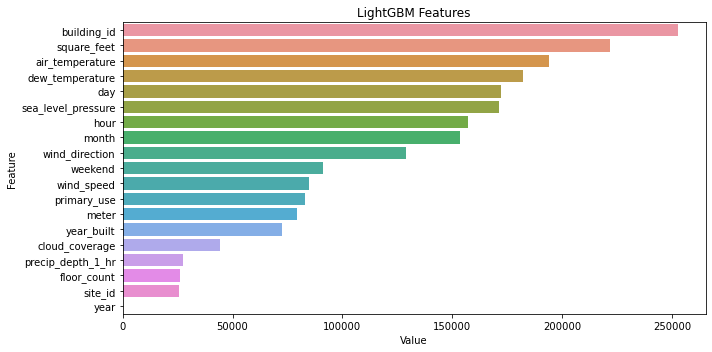

In [78]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

## Test preparation

In [114]:
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


In [115]:
clean_timestamps(test)
test = drop_cols(test)
test = test.drop('row_id', axis = 1)
test['primary_use'] = LabelEncoder().fit_transform(test['primary_use'])

In [83]:
submission = pd.read_csv('ashrae-energy-prediction/sample_submission.csv')

In [84]:
test_1 = test[:len(test)//3]
y_pred_1 = gbm.predict(test_1, num_iteration=gbm.best_iteration)

del test_1

gc.collect()

4

In [85]:
test_2 = test[len(test)//3:(len(test)*2)//3]
y_pred_2 = gbm.predict(test_2, num_iteration=gbm.best_iteration)

del test_2

gc.collect()

26

In [86]:
test_3 = test[(len(test)*2)//3:]
y_pred_3 = gbm.predict(test_3, num_iteration=gbm.best_iteration)

del test_3

gc.collect()

26

In [87]:
y_pred = np.concatenate([y_pred_1, y_pred_2, y_pred_3], axis=0)

del y_pred_1
del y_pred_2
del y_pred_3

gc.collect()

22

In [ ]:
y_pred = np.expm1(y_pred)
fix_predictions(y_pred)
submission['meter_reading'] = y_pred
submission

,row_id,meter_reading
0,0,0.000000
1,1,0.390544
2,2,0.117277
3,3,0.110357
4,4,0.328998
...,...,...
41697595,41697595,5.670367
41697596,41697596,4.319066
41697597,41697597,3.732885
41697598,41697598,96.122090


In [93]:
submission

,row_id,meter_reading
0,0,0.000000
1,1,0.390544
2,2,0.117277
3,3,0.110357
4,4,0.328998
...,...,...
41697595,41697595,5.670367
41697596,41697596,4.319066
41697597,41697597,3.732885
41697598,41697598,96.122090


## Submission

In [ ]:
# my_submission = pd.DataFrame({'row_id': test_x.row_id, 'meter_reading': y_pred})
# my_submission.to_csv('submission3.csv', index=False)

In [91]:
submission.to_csv('submission.csv', index=False)

In [92]:
!tar cvfz lgb.tar.gz submission.csv

submission.csv
